In [ ]:
# RiskMetrics

This notebook analyzes and compares risk metrics—Value at Risk (VaR), Conditional Value at Risk (CVaR), and Entropic Value at Risk (EVaR)—across three probability distributions: normal, t, and uniform. It computes theoretical values for each metric and simulates random samples to estimate them empirically. 

The results are visualized to show the distribution of estimates and how they compare to the true values, providing insights into the accuracy and variability of each risk measure under different distributional assumptions.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t, uniform
from scipy.optimize import minimize_scalar
import numfolio as nf

alpha = 0.05
mu = 0
sigma = 0.5
df = 2
a= -2
b = 2

def serve_normal(alpha, mu, sigma) -> dict:
    """Compute statistics for normal distribution"""
    return {
        'VaR': norm.ppf(q=1 - alpha, loc=- mu, scale=sigma),
        'CVaR': - mu + sigma * norm.pdf(norm.ppf(q=1 - alpha)) / alpha,
        'EVaR': mu + np.sqrt(-2. * np.log(alpha)) * sigma
    }

def serve_t(alpha, mu, sigma, df) -> dict:
    """Compute statistics for t distribution"""
    quantile = t.ppf(q=1 - alpha, df=df)
    return {
        'VaR': t.ppf(q=1 - alpha, df=2, loc=- mu, scale=sigma),
        'CVaR': - mu + sigma * (df + quantile ** 2) / (df - 1) * t.pdf(quantile, df=df) / alpha,
        'EVaR': mu + np.sqrt(-2. * np.log(alpha)) * sigma # Fake
    }

def objective(t: float, alpha: float, a: float = 0, b: float = 1) -> float:
    """Objective function for the EVaR for uniform distribution"""
    if t <= 0:
        return np.inf
    return t * np.log(t * (np.exp(b / t) - np.exp(a / t)) / (b - a)) - t * np.log(alpha)

def solve_evar(alpha, a, b):
    """Get the EVaR for uniform distribution"""
    res = minimize_scalar(
        objective,
        args=(alpha, a, b),
    )
    return res.fun

def serve_uniform(alpha, a, b) -> dict:
    """Compute statistics for uniform distribution"""
    return {
        'VaR': a + (1. - alpha) * (b - a),
        'CVaR': a + 0.5 * (2. - alpha) * (b - a),
        'EVaR': solve_evar(alpha, a, b)
    }

metrics = {
    'normal': serve_normal(alpha, mu, sigma),
    't': serve_t(alpha, mu, sigma, df),
    'uniform': serve_uniform(alpha, a, b)
}

metrics


{'normal': {'VaR': np.float64(0.8224268134757361),
  'CVaR': np.float64(1.0313564037537137),
  'EVaR': np.float64(1.2238734153404083)},
 't': {'VaR': np.float64(1.459992790177758),
  'CVaR': np.float64(3.082207001482958),
  'EVaR': np.float64(1.2238734153404083)},
 'uniform': {'VaR': 1.7999999999999998,
  'CVaR': 1.9,
  'EVaR': np.float64(1.9264241117657113)}}

In [38]:
N = 500
size = 500

rvs = {
    'normal': norm(loc=mu, scale=sigma),
    't': t(loc=mu, scale=sigma, df=df),
    'uniform': uniform(loc=a, scale=b-a)
}

results = []
for _ in range(N):

    for key, rv in rvs.items():
        returns = rv.rvs(size=size)
        
        r = {
            'VaR': nf.compute_var(returns, alpha=alpha),
            'CVaR': nf.compute_cvar(returns, alpha=alpha, n_step=500),
            'EVaR': nf.compute_evar(returns, alpha=alpha),
            'statistic': key,
            
        }
        results.append(r)

results = pd.DataFrame(results)

/home/adiiura/anaconda3/envs/numfolioenv3.12/lib/python3.12/site-packages/scipy/optimize/_optimize.py:3011: RuntimeWarning: invalid value encountered in scalar divide
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


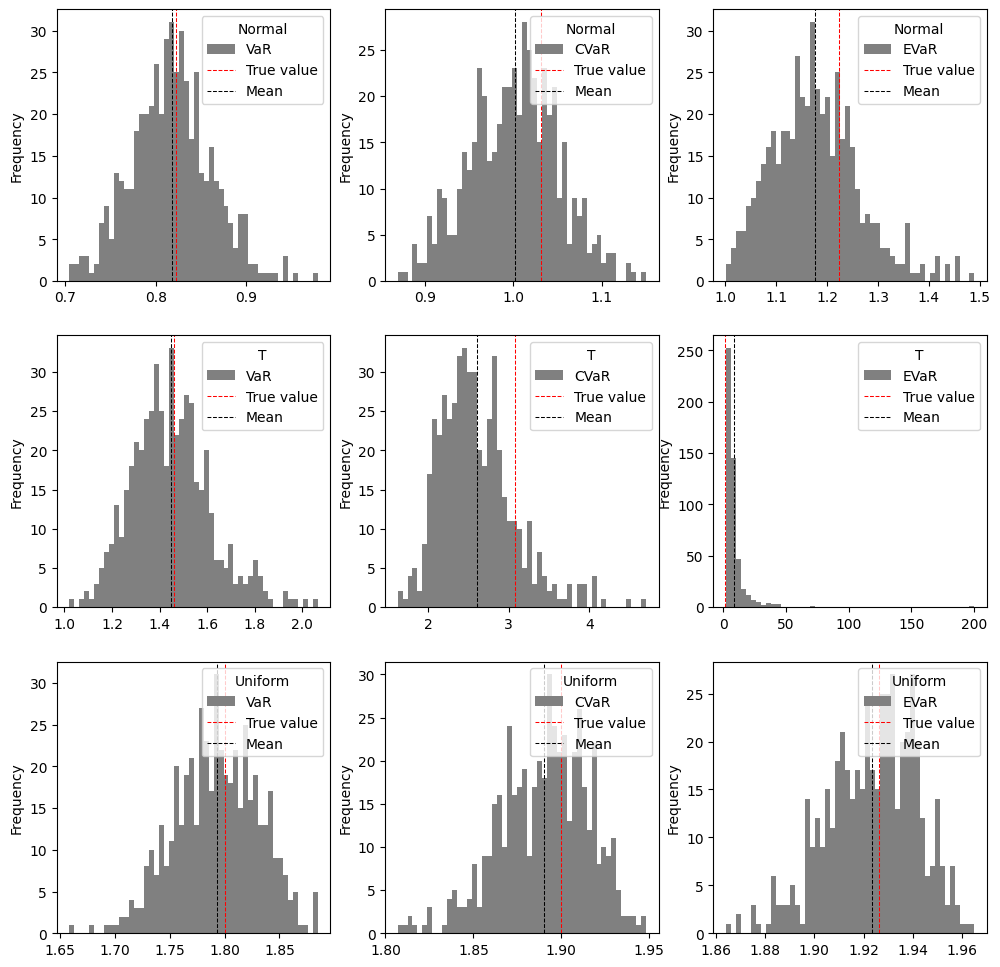

In [ ]:
import matplotlib.pyplot as plt
fig, grid = plt.subplots(3, 3, figsize=(12, 12))

for (key, m), axes in zip(metrics.items(), grid):
    for c, ax in zip(results.columns, axes):
        q = results.query(f'statistic == "{key}"')[c]
        q.plot(kind='hist', ax=ax, color='gray', bins=50)
    
        ax.axvline(m[c], color='red', linestyle='dashed', linewidth=0.75, label='True value')
        
        mean = q.mean()
        std = q.std()
        
        ax.axvline(mean, color='blue', linestyle='dashed', linewidth=0.75, label='Mean')
        ax.axvspan(
            mean - std, mean + std,
            color='blue', alpha=0.1, label='1 Std Dev'
        )
        ax.legend(loc=1, title=key)